In [49]:
#import torch
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler # 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Version 1
Seq to seq model: target use the scores + high + use rate

In [20]:
# read file
#data = pd.read_pickle('../data/thread_0_0_999.pkl')
data = pd.read_pickle('../results/new_sample.tmp')

## prepare the data
what kinds of data do we need
- vector representation of the 'Teile' 
- vector representation of the rotation
- number of knote in the Teile
- normalized area of teile
- normalized circle of teile
- normlized area/circle of teile
- normalized left down of teile
- normalized right down of teile
- normalized area/circle after convexing
- normalized length/width
- normalized centroid x/width
- normalized centroid y/length

In [22]:
df = data.copy()

In [23]:
# get unique type of shapely
polygon1 = df["Shapely Polygon"].iloc[0]
polygon2 = df["Shapely Polygon"].iloc[2]
polygon3 = df["Shapely Polygon"].iloc[3]
polygon4 = df["Shapely Polygon"].iloc[4]
polygon5 = df["Shapely Polygon"].iloc[15]
polygon6 = df["Shapely Polygon"].iloc[28]

In [24]:
# get features: area_quote, convec_area_quote
polygon_list = [polygon1,polygon2,polygon3,polygon4,polygon5,polygon6]

def area_quote_calculation(x):
    bounds_x = x.bounds[2]
    bounds_y = x.bounds[3]
    return x.area/(bounds_x*bounds_y)

def convex_area_quote_calculation(polygon):
    convex_hull_x, convex_hull_y = [z.tolist() for z in polygon.convex_hull.exterior.coords.xy]
    convex_polygon = Polygon(zip(convex_hull_x,convex_hull_y))
    convex_area_quote = convex_polygon.area/(convex_polygon.bounds[2]*convex_polygon.bounds[3])
    return convex_area_quote

result = []
for polygon in polygon_list:
    temp=[]
    temp.append(polygon)
    temp.append(area_quote_calculation(polygon))
    temp.append(convex_area_quote_calculation(polygon))
    temp.append(polygon.centroid.x/polygon.bounds[2])
    temp.append(polygon.centroid.y/polygon.bounds[3])
    temp.append(polygon.bounds[2]/polygon.bounds[3])
    result.append(temp)

In [25]:
features  = pd.DataFrame(result,columns=["Shapely Polygon", "area quote", 
                                          "convex area quote", "centroid x/width",
                                          "centroid y/height","width/height" ] )

In [26]:
# 面积  长度   面积使用率   变成凸以后，面积使用率  复杂度？  重心  长宽比

In [27]:
# get num of corr
df['num_of_corr'] = df['Shapely Polygon'].map(lambda x: len(list(x.boundary.coords)))
features["num_of_corr"] = features["Shapely Polygon"].map(lambda x:len(list(x.boundary.coords)))
del features["Shapely Polygon"]

In [28]:
# merge features to original dataframe
df =  pd.merge(df, features, how="left", left_on="num_of_corr",right_on="num_of_corr")

In [29]:
# get onehot data for 'Teile-Nr'
df = df.reset_index().iloc[:,1:]
# get onehot data
ohe = OneHotEncoder()
tmp = ohe.fit_transform(df['num_of_corr'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['s1', 's2', 's3', 's4', 's5', 's6']
df = pd.concat([df, tmp], axis = 1)

In [30]:
#df.isnull().values.any()

In [31]:
# get onehot data for rotation
df['Rot'][df['Rot'] == '5.00'] = '0.00'
# get onehot data
tmp = ohe.fit_transform(df['Rot'].values.reshape(-1, 1)).toarray()
tmp = pd.DataFrame(tmp)
tmp.columns = ['r1', 'r2']
df = pd.concat([df, tmp], axis = 1)

In [32]:
#df.head()

In [33]:
# change type of clumns for y
df['Metric2'] = pd.to_numeric(df['Metric2'])
df['Metric3'] = pd.to_numeric(df['Metric3'])
df['Metric4'] = pd.to_numeric(df['Metric4'])

In [34]:
# al = area /length
df['A/L'] = df['Area']/df['Length']

In [35]:
# get coordinate of echo value
df['Left_down_x'] = df['Left down'].map(lambda x: x[0])
df['Left_down_y'] = df['Left down'].map(lambda x: x[1])
df['Right_down_y'] = df['right down'].map(lambda x: x[1])

In [36]:
# normalize the area, Length, num_of_corr, Left_down_x, Left_down_y, Right_down_y, A/L ...
scaler_area = StandardScaler().fit(df['Area'].values.reshape(-1, 1))
scaler_length = StandardScaler().fit(df['Length'].values.reshape(-1, 1))
scaler_num_of_corr = StandardScaler().fit(df['num_of_corr'].values.reshape(-1, 1))
scaler_al = StandardScaler().fit(df['A/L'].values.reshape(-1, 1))

scaler_area_quote = StandardScaler().fit(df['area quote'].values.reshape(-1, 1))
scaler_convex_area_quote = StandardScaler().fit(df['convex area quote'].values.reshape(-1, 1))
scaler_centroid_x_width = StandardScaler().fit(df['centroid x/width'].values.reshape(-1, 1))
scaler_centroid_y_height = StandardScaler().fit(df['centroid y/height'].values.reshape(-1, 1))
scaler_widt_height = StandardScaler().fit(df['width/height'].values.reshape(-1, 1))

scaler_ldx = StandardScaler().fit(df['Left_down_x'].values.reshape(-1, 1))
scaler_ldy = StandardScaler().fit(df['Left_down_y'].values.reshape(-1, 1))
scaler_rdy = StandardScaler().fit(df['Right_down_y'].values.reshape(-1, 1))

In [37]:
df['norm_area'] = scaler_area.transform(df['Area'].values.reshape(-1, 1))
df['norm_length'] = scaler_length.transform(df['Length'].values.reshape(-1, 1))
df['norm_num_of_corr'] = scaler_num_of_corr.transform(df['num_of_corr'].values.reshape(-1, 1))
df['norm_A/L'] = scaler_al.transform(df['A/L'].values.reshape(-1, 1))

df['norm_area quote'] = scaler_area_quote.transform(df['area quote'].values.reshape(-1, 1))
df['norm_convex area quote'] = scaler_convex_area_quote.transform(df['convex area quote'].values.reshape(-1, 1))
df['norm_centroid x/width'] = scaler_centroid_x_width.transform(df['centroid x/width'].values.reshape(-1, 1))
df['norm_centroid y/height'] = scaler_centroid_y_height.transform(df['centroid y/height'].values.reshape(-1, 1))
df['norm_width/height'] = scaler_widt_height.transform(df['width/height'].values.reshape(-1, 1))

df['norm_left_down_x'] = scaler_ldx.transform(df['Left_down_x'].values.reshape(-1, 1))
df['norm_left_down_y'] = scaler_ldy.transform(df['Left_down_y'].values.reshape(-1, 1))
df['norm_right_down_y'] = scaler_rdy.transform(df['Right_down_y'].values.reshape(-1, 1))

In [38]:
# combine the sequence in one task and transform to numpy
df['Jobid'] = df['Jobid'].map(lambda x: x.split('_')[0]+'_'+x.split('_')[1])

result = []
for name, group in tqdm.tqdm(df.groupby('Jobid')):
    if len(group) == 50:
        temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                        'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                        'norm_centroid y/height', 'norm_width/height',
                        's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
    
        #print(temp_x.shape)
        temp_result = []
        for i in range(50):
            sub_group = group.iloc[:i+1, :]
            mean = sub_group["score"].mean()
            max_x = np.max(sub_group["Left_down_x"].values)
            norm_max_x = np.max(sub_group["norm_left_down_x"].values)
            max_y = np.max(sub_group["Right_down_y"].values)

            area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
            temp_result.append(mean+area_quote+0.5*norm_max_x)
        #print(len(temp_result))
        #print(temp_x.shape)
        result.append(pd.DataFrame(np.concatenate((temp_x.values.reshape(1, -1),np.array(temp_result).reshape(1,-1)),axis=1), index = [name]))

  2%|▏         | 495/20271 [00:20<11:50, 27.85it/s] 

KeyboardInterrupt: 

In [ ]:
Dataframe = pd.concat(result)

In [ ]:
#1000000

In [31]:
#df.head()

,Jobid,Rot,List of Coordinates,Shapely Polygon,Metric1,Metric2,Metric3,Metric4,Area,Length,Left down,score,right down,num_of_corr,area quote,convex area quote,centroid x/width,centroid y/height,width/height,s1,s2,s3,s4,s5,s6,r1,r2,A/L,Left_down_x,Left_down_y,Right_down_y,norm_area,norm_length,norm_num_of_corr,norm_A/L,norm_area quote,norm_convex area quote,norm_centroid x/width,norm_centroid y/height,norm_width/height,norm_left_down_x,norm_left_down_y,norm_right_down_y
0,92600-1250_7,0.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",17.00,132.000,849.000,5.000,4439.800,615.763,"(256.8, 849.0)",0.500,"(256.8, 903.5)",19,0.653,0.976,0.532,0.500,2.290,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,7.210,256.800,849.000,903.500,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,-0.897,-0.119,-0.343
1,92600-1250_7,90.00,"[(0.0, 9.0), (9.0, 0.0), (115.8, 0.0), (124.8,...","POLYGON ((0 9, 9 0, 115.8 0, 124.8 9, 124.8 45...",18.00,288.000,1354.000,4.000,4439.800,615.763,"(342.5, 1354.0)",4.000,"(342.5, 1478.8)",19,0.653,0.976,0.532,0.500,2.290,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,7.210,342.500,1354.000,1478.800,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,-0.744,0.947,0.703
2,92600-1250_7,90.00,"[(1.0, 123.3), (0.0, 122.3), (0.0, 93.3), (1.0...","POLYGON ((1 123.3, 0 122.3, 0 93.3, 1 92.3, 21...",19.00,386.000,1352.000,4.000,7228.382,901.580,"(509.3, 1352.0)",4.000,"(509.3, 1455.6)",55,0.566,0.801,0.517,0.580,0.840,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,8.017,509.300,1352.000,1455.600,-0.618,-0.124,2.119,-0.747,-0.502,-0.516,0.784,1.699,-0.755,-0.447,0.943,0.661
3,92600-1250_7,90.00,"[(6.0, 38.0), (7.1, 40.0), (97.5, 40.0), (98.7...","POLYGON ((6 38, 7.1 40, 97.5 40, 98.7 38, 98.7...",20.00,135.000,1186.000,2.000,23178.165,1448.933,"(175.0, 1186.0)",0.000,"(175.0, 1874.3)",17,0.842,0.910,0.432,0.523,17.207,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,15.997,175.000,1186.000,1874.300,1.110,1.097,-0.627,0.976,1.037,0.420,-1.398,0.180,2.136,-1.042,0.592,1.423
4,92600-1250_7,90.00,"[(28.5, 0.0), (60.1, 0.0), (84.4, 7.9), (88.3,...","POLYGON ((28.5 0, 60.1 0, 84.40000000000001 7....",21.00,491.000,1466.000,4.000,1103.760,192.719,"(511.0, 1466.0)",4.000,"(511.0, 1554.3)",13,0.625,0.819,0.501,0.457,4.415,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,5.727,511.000,1466.000,1554.300,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,-0.444,1.184,0.841


13771800

20000.0

In [25]:
Dataframe.to_csv("features_50labels.csv")

(50, 17)

0.03091740608215332


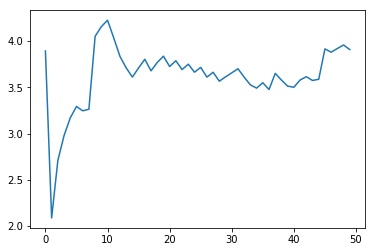

In [119]:
# for test
temp_x = group[['norm_area', 'norm_length', 'norm_num_of_corr', 'norm_A/L', 
                'norm_area quote', 'norm_convex area quote', 'norm_centroid x/width',
                'norm_centroid y/height', 'norm_width/height',
                's1', 's2', 's3', 's4', 's5', 's6', 'r1', 'r2']]#.values.reshape(1, -1)
x = []
temp_result = []
for i in range(50):
    sub_group = group.iloc[:i+1, :]
    mean = sub_group["score"].mean()
    max_x = np.max(sub_group["Left_down_x"].values)
    norm_max_x = np.max(sub_group["norm_left_down_x"].values)
    max_y = np.max(sub_group["Right_down_y"].values)

    area_quote = 1-sub_group["Area"].sum()/(max_x*max_y)
    temp_result.append(mean+area_quote+0.5*norm_max_x)
    x.append(mean+area_quote+0.5*norm_max_x)
plt.plot(x)
plt.show()

In [39]:
# read tmp result
result = pd.read_csv('../results/features_50labels.csv', index_col = 0)

In [40]:
result.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899
92600-1005_1,1.328,1.064,-0.193,1.315,-1.690,-1.739,-1.323,0.530,0.013,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.377,0.421,0.096,0.615,1.337,1.194,0.358,-0.429,-0.771,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,-0.920,-0.761,-0.482,-0.921,-0.018,0.989,1.181,-0.418,-0.499,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,-1.281,-1.705,-0.916,-1.241,-0.173,-0.361,0.393,-1.568,-0.124,1.000

In [41]:
train_x = result.iloc[:int(len(result)*0.9), :850].values.reshape(int(len(result)*0.9), 50, -1)
test_x = result.iloc[int(len(result)*0.9):, :850].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [42]:
train_y = result.iloc[:int(len(result)*0.9), 850:].values.reshape(int(len(result)*0.9), 50, -1)
test_y = result.iloc[int(len(result)*0.9):, 850:].values.reshape(len(result) - int(len(result)*0.9), 50, -1)

In [43]:
# save to the local system
np.save('../data/rnn_train_x', train_x)
np.save('../data/rnn_train_y', train_y)
np.save('../data/rnn_test_x', test_x)
np.save('../data/rnn_test_y', test_y)

## bild the rnn model

In [44]:
"""
bild the model, loss and data class, including two different versions
version 1:
seq to seq model
versioin 2:
seq to 1 model
"""
class TS_rnn(torch.nn.Module):
    """
    scores for each piece
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size, seq_len)
    """
    def __init__(self):
        super(TS_rnn, self).__init__()
        #change the structure of the network
        num_inp = 17
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 16),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(16, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # rnn the mlp
        batch_size, seq_len, num_dim = out_rnn.shape
        out = []
        for i in range(seq_len):
            tmp = self.mlp(out_rnn[:, i,:])
            out.append(tmp)
        # now out is list of (batch_size, 1), combine the items in the list to get the output with size (batch_size, seq_len)
        out = torch.cat(out, 1)
        #return out.squeeze() when the batch_size == 1, this can course trouble
        return out

class TS_rnn2(torch.nn.Module):
    """
    scores only for the whole task
    input:
        tensor size of (batch_size, seq_len, num_dim)
    output:
        tensor size of (batch_size)
    """
    def __init__(self):
        super(TS_rnn2, self).__init__()
        #change the structure of the network
        num_inp = 8
        num_hidden = 64
        self.rnn = torch.nn.LSTM(input_size = num_inp, hidden_size = num_hidden, num_layers = 2)
        self.mlp = torch.nn.Sequential(
                torch.nn.Linear(num_hidden, 64),
                torch.nn.Dropout(),
                torch.nn.ReLU(),
                torch.nn.Linear(64, 1)
                )

    def forward(self, inp):
        # input of the rnn (seq_len, batch, input_size)
        data_in = torch.transpose(inp, 0, 1)
        # run rnn, it has two output
        out_rnn, _ = self.rnn(data_in)
        out_rnn = torch.transpose(out_rnn, 0, 1) # (batch_size, seq_len, num_dim)
        # only use the last output
        out_rnn = out_rnn[:, -1, :].squeeze()
        # rnn the mlp
        out = self.mlp(out_rnn)
        return out.squeeze()
    
class PDLoss(torch.nn.Module):
    def __init__(self, p = 2):
        super(PDLoss, self).__init__()
        self.pd = torch.nn.PairwiseDistance(p)

    def forward(self, o, t):
        # out: (batch_size, 1)
        out = self.pd(o, t)
        return out.mean()

class Data:
    """
    data class for TS_rnn
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x).float()
        self.data['train_y'] = self.add_file(y)[:, :, -1].float() # use the first metric tempately
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

class Data2:
    """
    data class for TS_rnn2
    """
    def __init__(self, x, y):
        self.data = {}
        self.data['train_x'] = self.add_file(x)
        self.data['train_y'] = self.add_file(y)[:, :, -1] # use the first metric tempately
        self.data['train_y'] = torch.mean(self.data['train_y'], 1)
        assert(len(self.data['train_x']) == len(self.data['train_y']))
        self.len = len(self.data['train_x'])

    def add_file(self, path):
        return torch.from_numpy(np.load(path))

    def add_scores(self, path):
        return torch.FloatTensor([float(li.rstrip('\n')) for li in open(path)])

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return (self.data['train_x'][index],
                self.data['train_y'][index])

In [61]:
# write the test function
def test_model(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        test_loss += lo.data
    return test_loss/counter

def significant_test(dl_test, model, loss):
    model.eval()
    test_loss = 0
    counter = 0
    hit = 0
    miss = 0
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        # codes to be changed
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        #print(out.shape)
        out = out.mean(dim = 1)
        #print(out.shape)
        if len(inp) > 5:
            _, top_target = torch.topk(target, 1, largest = False)
            _, top_predict = torch.topk(out, 5, largest = False)
            if top_target in top_predict:
                hit += 1
            else:
                miss += 1
    return hit * 1.0/(hit + miss)

def metric2(dl_test, model, loss):
    model.eval()
    counter = 0
    hit_count = {}
    for batch_idx, dat in enumerate(dl_test):
        counter += 1
        inp, target = dat
        out = model(inp)
        target = target.mean(dim = 1)
        out = out.mean(dim = 1)
        if len(inp) > 5:
            _, index_top_target = torch.topk(target, 1, largest = False)
            _, index_rank = torch.topk(out, len(target), largest = False)
            index_rank = index_rank.tolist()
            index_in_rank = index_rank.index(index_top_target)
            if index_in_rank not in hit_count.keys():
                #print('create new key')
                hit_count[index_in_rank] = 1
            else:
                #print('add one')
                hit_count[index_in_rank] = hit_count[index_in_rank] + 1
    return hit_count

In [50]:
# run the model
train_x = '../data/rnn_train_x.npy'
train_y = '../data/rnn_train_y.npy'
test_x = '../data/rnn_test_x.npy'
test_y = '../data/rnn_test_y.npy'
num_epochs = 25
batch_size = 30
verbose = True
# set models and loss
model = TS_rnn()
#loss = PDLoss()
loss = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
# set the scheduler
lamb1 = lambda x: .1**(x//30)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lamb1)
# loda data
train = Data(train_x, train_y)
test = Data(test_x, test_y)
dl_train = DataLoader(train, batch_size = batch_size, shuffle = True)
dl_test = DataLoader(test, batch_size = batch_size, shuffle = True)
# train the model
for epoch in range(num_epochs):
    scheduler.step()
    model.train()
    train_loss = 0
    counter = 0
    for batch_idx, dat in enumerate(dl_train):
        counter += 1
        # train the model
        optimizer.zero_grad()
        inp, target = dat
        out = model(inp)
        lo = loss(out, target)
        lo.backward()
        optimizer.step()
        train_loss += lo.data
        if verbose:
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * batch_size,
                    len(train),
                    100.*batch_idx*batch_size/len(train),
                    lo.data
                    ))
    test_lo = test_model(dl_test, model, loss)
    hit_rate = significant_test(dl_test, model, loss)
    if verbose:
        # train loss
        print('====> Epoch: {} Average train loss: {:.4f}'.format(
            epoch,
            train_loss/counter
            ))
        # test loss
        print('====> Epoch: {} Average test loss: {:.4f}'.format(
            epoch,
            test_lo
            ))
        # significant test
        print('====> Epoch: {} Average hit rate in 10 candidate: {: .4f}'.format(
            epoch,
            hit_rate
        ))

Train Epoch: 0 [0/13771 (0%)]	Loss: 2.883015
Train Epoch: 0 [300/13771 (2%)]	Loss: 2.663920
Train Epoch: 0 [600/13771 (4%)]	Loss: 1.712425
Train Epoch: 0 [900/13771 (7%)]	Loss: 1.079447
Train Epoch: 0 [1200/13771 (9%)]	Loss: 1.058812
Train Epoch: 0 [1500/13771 (11%)]	Loss: 0.950884
Train Epoch: 0 [1800/13771 (13%)]	Loss: 0.927150
Train Epoch: 0 [2100/13771 (15%)]	Loss: 0.921322
Train Epoch: 0 [2400/13771 (17%)]	Loss: 0.991467
Train Epoch: 0 [2700/13771 (20%)]	Loss: 0.888644
Train Epoch: 0 [3000/13771 (22%)]	Loss: 0.874231
Train Epoch: 0 [3300/13771 (24%)]	Loss: 0.934321
Train Epoch: 0 [3600/13771 (26%)]	Loss: 0.902715
Train Epoch: 0 [3900/13771 (28%)]	Loss: 0.882717
Train Epoch: 0 [4200/13771 (30%)]	Loss: 0.867002
Train Epoch: 0 [4500/13771 (33%)]	Loss: 0.875083
Train Epoch: 0 [4800/13771 (35%)]	Loss: 0.892588
Train Epoch: 0 [5100/13771 (37%)]	Loss: 0.888272
Train Epoch: 0 [5400/13771 (39%)]	Loss: 0.863978
Train Epoch: 0 [5700/13771 (41%)]	Loss: 0.874317
Train Epoch: 0 [6000/13771 (44%

Train Epoch: 3 [6300/13771 (46%)]	Loss: 0.507802
Train Epoch: 3 [6600/13771 (48%)]	Loss: 0.505915
Train Epoch: 3 [6900/13771 (50%)]	Loss: 0.517471
Train Epoch: 3 [7200/13771 (52%)]	Loss: 0.492809
Train Epoch: 3 [7500/13771 (54%)]	Loss: 0.534427
Train Epoch: 3 [7800/13771 (57%)]	Loss: 0.473812
Train Epoch: 3 [8100/13771 (59%)]	Loss: 0.469906
Train Epoch: 3 [8400/13771 (61%)]	Loss: 0.482635
Train Epoch: 3 [8700/13771 (63%)]	Loss: 0.508368
Train Epoch: 3 [9000/13771 (65%)]	Loss: 0.470700
Train Epoch: 3 [9300/13771 (68%)]	Loss: 0.488236
Train Epoch: 3 [9600/13771 (70%)]	Loss: 0.501820
Train Epoch: 3 [9900/13771 (72%)]	Loss: 0.488839
Train Epoch: 3 [10200/13771 (74%)]	Loss: 0.472996
Train Epoch: 3 [10500/13771 (76%)]	Loss: 0.467562
Train Epoch: 3 [10800/13771 (78%)]	Loss: 0.486021
Train Epoch: 3 [11100/13771 (81%)]	Loss: 0.491415
Train Epoch: 3 [11400/13771 (83%)]	Loss: 0.480834
Train Epoch: 3 [11700/13771 (85%)]	Loss: 0.490153
Train Epoch: 3 [12000/13771 (87%)]	Loss: 0.492721
Train Epoch: 

Train Epoch: 6 [12600/13771 (91%)]	Loss: 0.307633
Train Epoch: 6 [12900/13771 (94%)]	Loss: 0.267148
Train Epoch: 6 [13200/13771 (96%)]	Loss: 0.300741
Train Epoch: 6 [13500/13771 (98%)]	Loss: 0.272625
====> Epoch: 6 Average train loss: 0.3139
====> Epoch: 6 Average test loss: 0.2318
====> Epoch: 6 Average hit rate in 10 candidate:  0.9608
Train Epoch: 7 [0/13771 (0%)]	Loss: 0.298484
Train Epoch: 7 [300/13771 (2%)]	Loss: 0.293299
Train Epoch: 7 [600/13771 (4%)]	Loss: 0.293494
Train Epoch: 7 [900/13771 (7%)]	Loss: 0.302013
Train Epoch: 7 [1200/13771 (9%)]	Loss: 0.291849
Train Epoch: 7 [1500/13771 (11%)]	Loss: 0.276750
Train Epoch: 7 [1800/13771 (13%)]	Loss: 0.283803
Train Epoch: 7 [2100/13771 (15%)]	Loss: 0.300652
Train Epoch: 7 [2400/13771 (17%)]	Loss: 0.295626
Train Epoch: 7 [2700/13771 (20%)]	Loss: 0.272906
Train Epoch: 7 [3000/13771 (22%)]	Loss: 0.308782
Train Epoch: 7 [3300/13771 (24%)]	Loss: 0.296225
Train Epoch: 7 [3600/13771 (26%)]	Loss: 0.295357
Train Epoch: 7 [3900/13771 (28%)]	

Train Epoch: 10 [4200/13771 (30%)]	Loss: 0.272190
Train Epoch: 10 [4500/13771 (33%)]	Loss: 0.239084
Train Epoch: 10 [4800/13771 (35%)]	Loss: 0.257750
Train Epoch: 10 [5100/13771 (37%)]	Loss: 0.302042
Train Epoch: 10 [5400/13771 (39%)]	Loss: 0.236940
Train Epoch: 10 [5700/13771 (41%)]	Loss: 0.277112
Train Epoch: 10 [6000/13771 (44%)]	Loss: 0.295868
Train Epoch: 10 [6300/13771 (46%)]	Loss: 0.247006
Train Epoch: 10 [6600/13771 (48%)]	Loss: 0.269765
Train Epoch: 10 [6900/13771 (50%)]	Loss: 0.267111
Train Epoch: 10 [7200/13771 (52%)]	Loss: 0.260518
Train Epoch: 10 [7500/13771 (54%)]	Loss: 0.273905
Train Epoch: 10 [7800/13771 (57%)]	Loss: 0.305689
Train Epoch: 10 [8100/13771 (59%)]	Loss: 0.262248
Train Epoch: 10 [8400/13771 (61%)]	Loss: 0.286721
Train Epoch: 10 [8700/13771 (63%)]	Loss: 0.270740
Train Epoch: 10 [9000/13771 (65%)]	Loss: 0.292292
Train Epoch: 10 [9300/13771 (68%)]	Loss: 0.283105
Train Epoch: 10 [9600/13771 (70%)]	Loss: 0.273056
Train Epoch: 10 [9900/13771 (72%)]	Loss: 0.257767


Train Epoch: 13 [9600/13771 (70%)]	Loss: 0.253642
Train Epoch: 13 [9900/13771 (72%)]	Loss: 0.254075
Train Epoch: 13 [10200/13771 (74%)]	Loss: 0.291596
Train Epoch: 13 [10500/13771 (76%)]	Loss: 0.278686
Train Epoch: 13 [10800/13771 (78%)]	Loss: 0.276825
Train Epoch: 13 [11100/13771 (81%)]	Loss: 0.256123
Train Epoch: 13 [11400/13771 (83%)]	Loss: 0.264574
Train Epoch: 13 [11700/13771 (85%)]	Loss: 0.279510
Train Epoch: 13 [12000/13771 (87%)]	Loss: 0.288221
Train Epoch: 13 [12300/13771 (89%)]	Loss: 0.233399
Train Epoch: 13 [12600/13771 (91%)]	Loss: 0.243451
Train Epoch: 13 [12900/13771 (94%)]	Loss: 0.241008
Train Epoch: 13 [13200/13771 (96%)]	Loss: 0.291562
Train Epoch: 13 [13500/13771 (98%)]	Loss: 0.243743
====> Epoch: 13 Average train loss: 0.2664
====> Epoch: 13 Average test loss: 0.2254
====> Epoch: 13 Average hit rate in 10 candidate:  0.9216
Train Epoch: 14 [0/13771 (0%)]	Loss: 0.282878
Train Epoch: 14 [300/13771 (2%)]	Loss: 0.269925
Train Epoch: 14 [600/13771 (4%)]	Loss: 0.259335
Tra

Train Epoch: 17 [300/13771 (2%)]	Loss: 0.259006
Train Epoch: 17 [600/13771 (4%)]	Loss: 0.280760
Train Epoch: 17 [900/13771 (7%)]	Loss: 0.281591
Train Epoch: 17 [1200/13771 (9%)]	Loss: 0.228759
Train Epoch: 17 [1500/13771 (11%)]	Loss: 0.268460
Train Epoch: 17 [1800/13771 (13%)]	Loss: 0.246988
Train Epoch: 17 [2100/13771 (15%)]	Loss: 0.232772
Train Epoch: 17 [2400/13771 (17%)]	Loss: 0.248482
Train Epoch: 17 [2700/13771 (20%)]	Loss: 0.276977
Train Epoch: 17 [3000/13771 (22%)]	Loss: 0.235138
Train Epoch: 17 [3300/13771 (24%)]	Loss: 0.256327
Train Epoch: 17 [3600/13771 (26%)]	Loss: 0.272905
Train Epoch: 17 [3900/13771 (28%)]	Loss: 0.274266
Train Epoch: 17 [4200/13771 (30%)]	Loss: 0.270140
Train Epoch: 17 [4500/13771 (33%)]	Loss: 0.269876
Train Epoch: 17 [4800/13771 (35%)]	Loss: 0.263166
Train Epoch: 17 [5100/13771 (37%)]	Loss: 0.287456
Train Epoch: 17 [5400/13771 (39%)]	Loss: 0.233170
Train Epoch: 17 [5700/13771 (41%)]	Loss: 0.262710
Train Epoch: 17 [6000/13771 (44%)]	Loss: 0.256990
Train E

Train Epoch: 20 [5700/13771 (41%)]	Loss: 0.276391
Train Epoch: 20 [6000/13771 (44%)]	Loss: 0.264806
Train Epoch: 20 [6300/13771 (46%)]	Loss: 0.233681
Train Epoch: 20 [6600/13771 (48%)]	Loss: 0.256631
Train Epoch: 20 [6900/13771 (50%)]	Loss: 0.247526
Train Epoch: 20 [7200/13771 (52%)]	Loss: 0.275903
Train Epoch: 20 [7500/13771 (54%)]	Loss: 0.248748
Train Epoch: 20 [7800/13771 (57%)]	Loss: 0.261233
Train Epoch: 20 [8100/13771 (59%)]	Loss: 0.282388
Train Epoch: 20 [8400/13771 (61%)]	Loss: 0.262355
Train Epoch: 20 [8700/13771 (63%)]	Loss: 0.290494
Train Epoch: 20 [9000/13771 (65%)]	Loss: 0.268957
Train Epoch: 20 [9300/13771 (68%)]	Loss: 0.282681
Train Epoch: 20 [9600/13771 (70%)]	Loss: 0.260498
Train Epoch: 20 [9900/13771 (72%)]	Loss: 0.281622
Train Epoch: 20 [10200/13771 (74%)]	Loss: 0.258147
Train Epoch: 20 [10500/13771 (76%)]	Loss: 0.251446
Train Epoch: 20 [10800/13771 (78%)]	Loss: 0.279082
Train Epoch: 20 [11100/13771 (81%)]	Loss: 0.251182
Train Epoch: 20 [11400/13771 (83%)]	Loss: 0.27

Train Epoch: 23 [11100/13771 (81%)]	Loss: 0.274527
Train Epoch: 23 [11400/13771 (83%)]	Loss: 0.278853
Train Epoch: 23 [11700/13771 (85%)]	Loss: 0.226501
Train Epoch: 23 [12000/13771 (87%)]	Loss: 0.236566
Train Epoch: 23 [12300/13771 (89%)]	Loss: 0.279425
Train Epoch: 23 [12600/13771 (91%)]	Loss: 0.243545
Train Epoch: 23 [12900/13771 (94%)]	Loss: 0.247842
Train Epoch: 23 [13200/13771 (96%)]	Loss: 0.226954
Train Epoch: 23 [13500/13771 (98%)]	Loss: 0.240075
====> Epoch: 23 Average train loss: 0.2566
====> Epoch: 23 Average test loss: 0.2147
====> Epoch: 23 Average hit rate in 10 candidate:  0.8824
Train Epoch: 24 [0/13771 (0%)]	Loss: 0.271326
Train Epoch: 24 [300/13771 (2%)]	Loss: 0.257073
Train Epoch: 24 [600/13771 (4%)]	Loss: 0.217717
Train Epoch: 24 [900/13771 (7%)]	Loss: 0.245433
Train Epoch: 24 [1200/13771 (9%)]	Loss: 0.260987
Train Epoch: 24 [1500/13771 (11%)]	Loss: 0.262583
Train Epoch: 24 [1800/13771 (13%)]	Loss: 0.254016
Train Epoch: 24 [2100/13771 (15%)]	Loss: 0.228391
Train Epo

In [51]:
# save model
torch.save(model, '../models/rnn_predict.pkl')

In [126]:
# value the model with metric2
hit_count = metric2(dl_test, model, loss)

In [127]:
hit_list = [hit_count[i] if i in hit_count.keys() else 0 for i in range(30)]

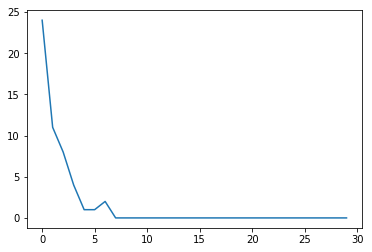

In [128]:
plt.plot(hit_list)

In [ ]:
#?? how to get the weight of a mlp model in pytorch

In [157]:
mod = torch.nn.LSTM(input_size = 17, hidden_size = 64, num_layers = 3, dropout = 0.5)

In [173]:
parms = model.mlp.

In [176]:
parms.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
c = np.load('../data/rnn_train_y.npy')
c = torch.from_numpy(c)

In [181]:
a = torch.FloatTensor([3,2,3,2])
b = torch.FloatTensor([3,2,4,5])

In [190]:
c = torch.stack([a, b], dim = 0)

In [193]:
torch.std(c, dim = 1)

tensor([0.5774, 1.2910])

In [198]:
lamb1 = lambda x: 0.01 * 0.1**((x%100)//30)

In [206]:
lamb1(122)

0.01

In [205]:
pdist = torch.nn.PairwiseDistance(p=2)

# result study
- 比较loss和sig的变化： test_loss, test_sig
    - correlation的变化关系随着观察的层数的增加而下降
    - [:10] - 0.56; [:20] - 0.49; [:30] - 0.43; [:40] - 0.33
    - 10以后loss趋向于稳定但是sig的变化还是很大， 有可能是hit rate上去后，随机因素的影响被放大了
- 比较loss和单个weight的变化：test_loss，mean_mod_wh_l0'
    - weight都是在热重启后60的epoch后进入稳定期（可能是由于schedule的原因导致的），而且稳定后的数值一般是不一样的。
    - 目标函数从一个坑跳进另一个坑, 一般在热重启的时候进行跳坑。
- 比较weight之间的关系

In [5]:
test_loss = torch.load('../results/test_loss.pkl')
test_sig = torch.load('../results/test_sig.pkl')

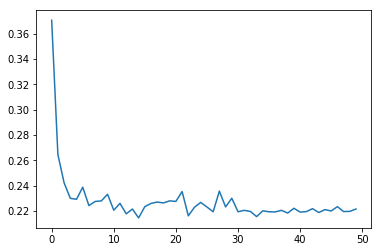

In [6]:
plt.plot(test_loss[:50])

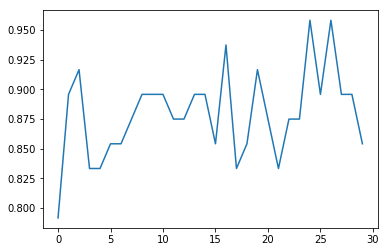

In [14]:
plt.plot(test_sig[:30])
#plt.figure(figsize = (100, 140))
plt.savefig('../results/test.png', dpi = 200)

In [287]:
np.corrcoef(test_loss[10:30], test_sig[10:30])

array([[ 1.        , -0.23642227],
       [-0.23642227,  1.        ]])

In [288]:
mean_mod_wh_l0 = torch.load('../results/mean_mod_wh_l0')
mean_mod_wh_l1 = torch.load('../results/mean_mod_wh_l1')
mean_mod_wi_l0 = torch.load('../results/mean_mod_wi_l0')
mean_mod_wi_l1 = torch.load('../results/mean_mod_wi_l1')

In [291]:
dat = mean_mod_wh_l1

In [292]:
dat = torch.stack(dat, dim = 2)

In [293]:
a = dat[1,1,:]

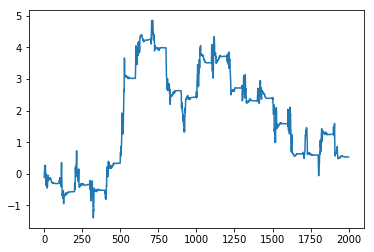

In [294]:
plt.plot(dat[0,1,].tolist())

In [ ]:
数据的单位是epoch，也就是说所有的数据都会被挨个使用一遍。相同数据，同一个weight，为什么数值有时候上升有时候下降呢？？？

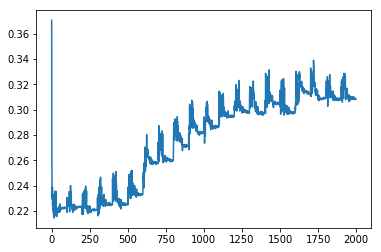

In [295]:
plt.plot(test_loss)

In [296]:
# 比较weights之间的关系
stds = torch.std(dat, dim =2 )

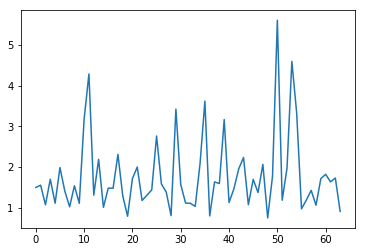

In [297]:
plt.plot(stds[0,:].tolist())

In [15]:
# model test 

In [19]:
model = torch.load('../models/rnn_24.pkl')

AttributeError: Can't get attribute '_rebuild_parameter' on <module 'torch._utils' from '/anaconda3/envs/data_mining/lib/python3.6/site-packages/torch/_utils.py'>

In [ ]:
#
area_quote_6 = polygon6.area/(polygon6.bounds[2]*polygon6.bounds[3])
#
convex_hull_x, convex_hull_y = [z.tolist() for z in polygon6.convex_hull.exterior.coords.xy]
convex_polygon6 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_6 = convex_polygon6.area/(convex_polygon6.bounds[2]*convex_polygon6.bounds[3])
# 
print("the area use quote is : " , area_quote_6)
print("the area use quote of convex is : " , convex_area_quote_6)
print("the number of ecke :" , len(polygon6.boundary.coords))
print(polygon6.centroid)


area_quote_5 = polygon5.area/(polygon5.bounds[2]*polygon5.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon5.convex_hull.exterior.coords.xy]
convex_polygon5 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_5 = convex_polygon5.area/(convex_polygon5.bounds[2]*convex_polygon5.bounds[3])

print("the area use quote is : " , area_quote_5)
print("the area use quote of convex is : " , convex_area_quote_5)
print("the number of ecke :" , len(polygon5.boundary.coords))


area_quote_4 = polygon4.area/(polygon4.bounds[2]*polygon4.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon4.convex_hull.exterior.coords.xy]
convex_polygon4 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_4 = convex_polygon4.area/(convex_polygon4.bounds[2]*convex_polygon4.bounds[3])

print("the area use quote is : " , area_quote_4)
print("the area use quote of convex is : " , convex_area_quote_4)
print("the number of ecke :" , len(polygon4.boundary.coords))

area_quote_3 = polygon3.area/(polygon3.bounds[2]*polygon3.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon3.convex_hull.exterior.coords.xy]
convex_polygon3 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_3 = convex_polygon3.area/(convex_polygon3.bounds[2]*convex_polygon3.bounds[3])


print("the area use quote is : " , area_quote_3)
print("the area use quote of convex is : " , convex_area_quote_3)
print("the number of ecke :" , len(polygon3.boundary.coords))

area_quote_2 = polygon2.area/(polygon2.bounds[2]*polygon2.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon2.convex_hull.exterior.coords.xy]
convex_polygon2 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_2 = convex_polygon2.area/(convex_polygon2.bounds[2]*convex_polygon2.bounds[3])


print("the area use quote is : " , area_quote_2)
print("the area use quote of convex is : " , convex_area_quote_2)
print("the number of ecke :" , len(polygon2.boundary.coords))


area_quote_1 = polygon1.area/(polygon1.bounds[2]*polygon1.bounds[3])

convex_hull_x, convex_hull_y = [z.tolist() for z in polygon1.convex_hull.exterior.coords.xy]
convex_polygon1 = Polygon(zip(convex_hull_x,convex_hull_y))
convex_area_quote_1 = convex_polygon1.area/(convex_polygon1.bounds[2]*convex_polygon1.bounds[3])


print("the area use quote is : " , area_quote_1)
print("the area use quote of convex is : " , convex_area_quote_1)


a = [[polygon6, area_quote_6, convex_area_quote_6, polygon6.centroid.x, polygon6.centroid.y, convex_polygon6.bounds[2]/convex_polygon6.bounds[3]],
    [polygon5, area_quote_5, convex_area_quote_5, polygon5.centroid.x, polygon5.centroid.y, convex_polygon5.bounds[2]/convex_polygon5.bounds[3]],
    [polygon4, area_quote_4, convex_area_quote_4, polygon4.centroid.x, polygon4.centroid.y, convex_polygon4.bounds[2]/convex_polygon4.bounds[3]],
    [polygon3, area_quote_3, convex_area_quote_3, polygon3.centroid.x, polygon3.centroid.y, convex_polygon3.bounds[2]/convex_polygon3.bounds[3]],
    [polygon6, area_quote_2, convex_area_quote_2, polygon2.centroid.x, polygon2.centroid.y, convex_polygon2.bounds[2]/convex_polygon2.bounds[3]],
    [polygon6, area_quote_1, convex_area_quote_1, polygon1.centroid.x, polygon1.centroid.y, convex_polygon1.bounds[2]/convex_polygon1.bounds[3]]]

